![UiO Logo](https://www.uio.no/om/designmanual/images/1-2-3-logo-universitetet-i-oslo.jpg "UiO Logo")

# KNN Example
by Marius Aasan (mariuaas$(\alpha)$math$\cdot$uio$\cdot$no) - IN3050/4050 Group 3 - 22.02.2021 1015-1200

This is the beginnings of a practical implementation of the KNN-algortithm, which only evaluates in-sample points. A full implementation must be generalized to evaluate points not previously seen in training, which will be part of the mandatory exercises. 

In [1]:
%matplotlib inline

We import our old workhorses, numpy and matplotlib :)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We start by synthesizing some data. We set a number of samples we want to create for each class.

In [3]:
n = 25

To generate the two classes, we essentially sample from the standard normal distribution $\mathcal N (0, 1)$ and apply an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) to each so they overlap a little.

In [4]:
cl0 = np.random.randn(n, 2) @ np.array([[1, -0.6],[1, 0.4]]) + np.array([-1, 0.8])
cl1 = np.random.randn(n, 2) @ np.array([[0.7, 1], [0.8, 0.3]]) + np.array([0.5, -0.4])

Let's have a look at how the data is distributed.

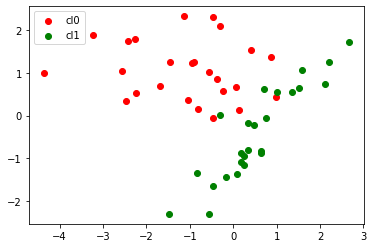

In [5]:
plt.scatter(cl0[:,0], cl0[:,1], color="red", label="cl0")
plt.scatter(cl1[:,0], cl1[:,1], color="green", label="cl1")
plt.legend();

Pretty good! Now we want to add all the data together in an array and shuffle it. Remember, the `np.random.shuffle` function is always applied in-place.

In [6]:
cl0 = np.hstack([cl0, np.zeros((n,1))])
cl1 = np.hstack([cl1, np.ones((n,1))])

data = np.vstack([cl0, cl1])
np.random.shuffle(data)

Now all our data is in a single matrix, and the last column is our binary classification. Click on the side to see how this looks.

In [7]:
data

array([[-5.66292730e-01,  1.01194757e+00,  0.00000000e+00],
       [ 6.44528814e-01, -8.27392828e-01,  1.00000000e+00],
       [ 3.46839435e-01, -8.14689178e-01,  1.00000000e+00],
       [-4.72051902e-01, -5.75783235e-02,  0.00000000e+00],
       [ 1.81410028e-01, -1.08627800e+00,  1.00000000e+00],
       [ 2.65547906e+00,  1.73873437e+00,  1.00000000e+00],
       [ 1.01718815e+00,  5.57297777e-01,  1.00000000e+00],
       [ 1.67672572e-01, -8.82226193e-01,  1.00000000e+00],
       [-5.56028949e-01, -2.30931858e+00,  1.00000000e+00],
       [-1.74108846e-01, -1.45072245e+00,  1.00000000e+00],
       [ 3.99594040e-01,  1.53266187e+00,  0.00000000e+00],
       [-1.67670665e+00,  6.95266249e-01,  0.00000000e+00],
       [ 1.50800344e+00,  6.48879160e-01,  1.00000000e+00],
       [-8.32378115e-01, -1.35413037e+00,  1.00000000e+00],
       [ 1.58258841e+00,  1.06881850e+00,  1.00000000e+00],
       [-2.24268701e+00,  5.29889288e-01,  0.00000000e+00],
       [ 4.67217305e-01, -2.23896797e-01

The next point of order is to create a distance function which can be applied to create a distance matrix for our data. We first make a naive Python implementation and see how long it takes to run.

In [8]:
%%time

def distance(x, y):
    return np.linalg.norm(y - x, 2)

distances = -np.ones((n, n))
for i in range(n):
    for j in range(i, n):
        dis = distance(data[i,:2], data[j,:2])
        distances[i,j] = dis
        distances[j,i] = dis

Wall time: 3.96 ms


Actually, SciPy has a very nice implementation for this exact problem. 

In [9]:
from scipy.spatial import distance_matrix

This is a lot faster than our naive implementation.

In [10]:
%%time

distances = distance_matrix(data[:,:2], data[:,:2])

Wall time: 0 ns


It might not seem like much, but for bigger datasets, the difference becomes more apparent.

Next we create a function which sorts the indices of the distances in a given row of the matrix.

In [11]:
def knn_indices(idx, k):
    return np.argsort(distances[idx])[:k]

We use this to find the indices of the three closest neigbours.

In [12]:
knn_indices(22, 3)

array([22,  4, 39], dtype=int64)

Then we can index our data with these indices and retrieve their classes from column 2.

In [13]:
data[knn_indices(22, 3),2]

array([1., 1., 1.])

We formalize this with a function, where we retrieve the indices, get the classes, and return the majority.

In [14]:
def knn_class(idx, k):
    indices = knn_indices(idx, k)
    classes = data[indices]
    zeros = np.sum(classes == 0)
    ones = np.sum(classes == 1)
    if zeros > ones:
        return 0
    else:
        return 1

data_predict = np.array([knn_class(i, 3) for i in range(len(data))])

Let's see how well the KNN with 3 neighbours predicts our dataset. We generate the data of the confusion matrix, a particularily useful method to see how accurate our method is. 

We do this by simply generating boolean arrays which we later combine.

In [15]:
pred_cl0 = data_predict == 0 # Boolean array of predicted class 0
pred_cl1 = data_predict == 1 # Boolean array of predicted class 1
act_cl0 = data[:,2] == 0 # Boolean array of true class 0
act_cl1 = data[:,2] == 1 # Boolean array of true class 1

tn = pred_cl0 & act_cl0 # True negatives
fn = pred_cl0 & act_cl1 # False negatives
tp = pred_cl1 & act_cl1 # True positives
fp = pred_cl1 & act_cl0 # False positives

Now we visualize these predictions.

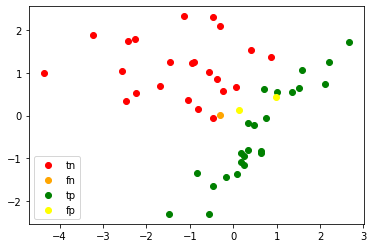

In [16]:
plt.scatter(data[tn, 0], data[tn, 1], color="red", label="tn")
plt.scatter(data[fn, 0], data[fn, 1], color="orange", label="fn")
plt.scatter(data[tp, 0], data[tp, 1], color="green", label="tp")
plt.scatter(data[fp, 0], data[fp, 1], color="yellow", label="fp")
plt.legend();

Lastly, we print the different accuracy scores.

In [39]:
print(f"accuracy: {np.sum(data_predict == data[:,2]) / len(data)}")
print(f"tp: {np.sum(tp) / len(data)}")
print(f"fp: {np.sum(fp) / len(data)}")
print(f"tn: {np.sum(tn) / len(data)}")
print(f"fn: {np.sum(fn) / len(data)}")

accuracy: 0.84
tp: 0.48
fp: 0.14
tn: 0.36
fn: 0.02


In a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), these numbers are presented in a table like this

|   | P  | N  |
|---|----|----|
| P | TP | FP |
| N | FP | TN |